# Imports

In [1]:
## load packages 
import pandas as pd
import re
import numpy as np

## nltk imports
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize

## uncomment and download if this is your first time running 
# nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger_eng')

## sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## spacy --- if you get an error at the load step
## ! python -m spacy download en_core_web_sm
import spacy
sp = spacy.load('en_core_web_sm')
import en_core_web_sm
nlp = en_core_web_sm.load()

## specify to print all output in a call
## and not just first
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Load data 

In [ ]:
## if working from within the repo, can use this relative path
data_path = "../../public_data/airbnb_text.csv"

## load data
ab = pd.read_csv(data_path)
ab.head()
ab.info()

,id,name,name_upper,neighbourhood_group,price
0,2539,Clean & quiet apt home by the park,CLEAN & QUIET APT HOME BY THE PARK,Brooklyn,149
1,2595,Skylit Midtown Castle,SKYLIT MIDTOWN CASTLE,Manhattan,225
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,150
3,3831,Cozy Entire Floor of Brownstone,COZY ENTIRE FLOOR OF BROWNSTONE,Brooklyn,89
4,5022,Entire Apt: Spacious Studio/Loft by central park,ENTIRE APT: SPACIOUS STUDIO/LOFT BY CENTRAL PARK,Manhattan,80


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   48895 non-null  int64 
 1   name                 48879 non-null  object
 2   name_upper           48879 non-null  object
 3   neighbourhood_group  48895 non-null  object
 4   price                48895 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.9+ MB


# Text mining

## Manual approach 1: look for a single word

In [4]:
## using the `name_upper` var, look at where reviews mention cozy
ab['is_cozy'] = np.where(ab.name_upper.str.contains("COZY"), True, False)

## find the mean price by neighborhood and whether cozy
mp = pd.DataFrame(ab.groupby(['is_cozy', 'neighbourhood_group'])['price'].mean())

## reshape to wide format so that each borough is row
## and one col is the mean price for listings that describe
## the place as cozy; other col is mean price for listings
## without that word
mp_wide = pd.pivot_table(mp, index = ['neighbourhood_group'],
                        columns = ['is_cozy'])

mp_wide.columns = ['no_mention_cozy', 'mention_cozy']

mp_wide

,no_mention_cozy,mention_cozy
neighbourhood_group,,
Bronx,89.231088,74.214286
Brooklyn,128.175441,91.130224
Manhattan,204.109775,129.917140
Queens,102.596682,80.344388
Staten Island,120.650307,74.319149


### Practice: Look for word 'entire'

Repeat the previous code block, but this time create a new indicator for whether a listing name contains the word 'entire' and compare the prices across neighborhoods for listings with and without this word.

In [5]:
# solution
## using the `name_upper` var, look at where reviews mention cozy
ab['is_entire'] = np.where(ab.name_upper.str.contains("ENTIRE"), True, False)

## find the mean price by neighborhood and whether cozy
mp = pd.DataFrame(ab.groupby(['is_entire', 'neighbourhood_group'])['price'].mean())

## reshape to wide format so that each borough is row
## and one col is the mean price for listings that describe
## the place as cozy; other col is mean price for listings
## without that word
mp_wide = pd.pivot_table(mp, index = ['neighbourhood_group'],
                        columns = ['is_entire'])

mp_wide.columns = ['no_mention_entire', 'mention_entire']

mp_wide

,no_mention_entire,mention_entire
neighbourhood_group,,
Bronx,87.055037,112.421053
Brooklyn,123.879816,160.547101
Manhattan,196.969066,188.109649
Queens,99.110792,125.306818
Staten Island,114.439891,134.285714


## Manual approach 2: score based on dictionary of words

In [6]:
## construct dictionary
space_indicators = {
  'small': ['COZY', 'COMFY', 'LITTLE', 'SMALL'],
  'large': ['SPACIOUS', 'LARGE', 'HUGE', 'GIANT']
}


## for each listing, find the number of occurrences
## of words in each key

### first, let's test with one listing
practice_listing = "NICE AND COZY LITTLE APT AVAILABLE"

### splitting that string at space and looking at overlap with each key
### first, look at overlap with the list containing words for small
words_overlap_small = [word 
                    for word in practice_listing.split(" ") if 
                      word in space_indicators['small']]
words_overlap_small

['COZY', 'LITTLE']

In [7]:
### then, look at overlap with the list containing words for large
words_overlap_large = [word for word in practice_listing.split(" ") if 
                      word in space_indicators['large']]
words_overlap_large

### could then take length as a fraction of all words
len(words_overlap_small)/len(practice_listing.split(" "))
len(words_overlap_large)/len(practice_listing.split(" "))


[]

0.3333333333333333

0.0

### Practice: Score another listing

Using the same `space indicators` we just defined, score the following listing based on the proportion of words that belong to the "small" terms vs. the "large terms". Based on the scoring, would you say this place is "large", "small", or somewhere in-between?

In [8]:
practice_listing_new = "SPACIOUS PRIVATE BED & LARGE LIVING ROOM W/ OWN ENTRANCE IN COZY CELLAR"

In [9]:
# solution
## split words and check overlap
words_overlap_small_new = [word 
                           for word in practice_listing_new.split(" ") if 
                           word in space_indicators['small']]

### look at overlap with the list containing words for large
words_overlap_large_new = [word for word in practice_listing_new.split(" ") if 
                           word in space_indicators['large']]

### then take length as a fraction of all words
len(words_overlap_small_new)/len(practice_listing_new.split(" "))
len(words_overlap_large_new)/len(practice_listing_new.split(" "))


0.07692307692307693

0.15384615384615385

Seems like the listing leans toward being of "large" size!

## Part of speech tagging

In [10]:
## specify example
example_for_tag = "This is a chill apt next to the subway in LES Chinatown"
example_for_tag

'This is a chill apt next to the subway in LES Chinatown'

In [11]:
## try part of speech tagging using nltk
tokens = word_tokenize(example_for_tag) # Generate list of tokens
tokens_pos = pos_tag(tokens) # generate part of speech tags for those tokens
 
## returns a list of tuples
## first element in tuple is a word
## second element in tuple is the part of speech
#for one_tok in tokens_pos:
 #   print(one_tok)
tokens_pos

[('This', 'DT'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('chill', 'NN'),
 ('apt', 'JJ'),
 ('next', 'JJ'),
 ('to', 'TO'),
 ('the', 'DT'),
 ('subway', 'NN'),
 ('in', 'IN'),
 ('LES', 'NNP'),
 ('Chinatown', 'NNP')]

In [12]:
## use list iteration to extract proper nouns (NNP)
## i'm first checking if the second element in the tuple
## is equal to NNP
## if so, i'm returning the first element in the tuple (the 
## actual word)
all_prop_noun = [one_tok[0] for one_tok in tokens_pos 
                if one_tok[1] == "NNP"]
all_prop_noun

all_adj_noun = [one_tok[0] for one_tok in tokens_pos 
                if one_tok[1] == "JJ" or 
               one_tok[1] == "NN"]
all_adj_noun

['LES', 'Chinatown']

['chill', 'apt', 'next', 'subway']

## Named Entity Recognition

In [13]:
## a recent article
article = """
Faculty Draw the Line: Dartmouth Pushes Back on Federal Compact
by Noah Sullivan, October 13, 2025, appeared on The Dartmouth Independent
It’s not every day that over five hundred professors at Dartmouth speak with one voice. But that’s what happened this October, when more than half the faculty signed a petition asking President Sian Leah Beilock to reject a federal compact tied to the Trump administration. The deal, pitched as a way to boost funding for research and infrastructure, comes with strings attached. Those strings, according to the petition, would cut into Dartmouth’s ability to govern itself and protect academic freedom. That’s a line many here aren’t willing to cross.
The petition didn’t mince words. It said the compact would “undermine” the College’s independence and open the door to political interference. Faculty from across departments signed on, from physics to philosophy. Some said they’d never seen this kind of unity before. Others said it was long overdue. Either way, the message was clear: don’t trade values for money.
President Beilock responded with a campus-wide email. She said Dartmouth would never compromise its academic freedom or self-governance. She also said the College was still reviewing the compact and hadn’t made a final decision. That didn’t quiet the conversation. If anything, it made folks more curious. What’s in this compact? Why was Dartmouth one of the nine schools asked to sign? And what happens if we say no?
The compact, officially called the “Compact for Academic Excellence in Higher Education,” lays out a set of federal expectations. Schools that sign agree to certain admissions policies, student life rules, and curriculum standards. In return, they get priority access to federal grants and partnerships. Critics say it’s a backdoor way to control what colleges teach and who they admit. Supporters argue it’s a way to make sure taxpayer money goes to schools that meet national goals.
At Dartmouth, the debate isn’t just about policy. It’s about identity. This is a place that prides itself on independence. Faculty govern their own departments. Students shape campus life. Decisions are made locally, not handed down from Washington. That’s part of what makes Dartmouth, well, Dartmouth. So when a deal comes along that could change that, people pay attention.
"""

In [14]:
spacy_article = nlp(article)
print(type(spacy_article))

<class 'spacy.tokens.doc.Doc'>


In [15]:
## try a couple variations
for one_tok in spacy_article.ents:
    print("Entity: " + one_tok.text + "; NER tag: " + one_tok.label_)

Entity: Faculty Draw the Line: Dartmouth Pushes Back; NER tag: WORK_OF_ART
Entity: Federal Compact; NER tag: ORG
Entity: Noah Sullivan; NER tag: PERSON
Entity: October 13, 2025; NER tag: DATE
Entity: The Dartmouth Independent; NER tag: ORG
Entity: over five hundred; NER tag: CARDINAL
Entity: Dartmouth; NER tag: ORG
Entity: one; NER tag: CARDINAL
Entity: this October; NER tag: DATE
Entity: more than half; NER tag: CARDINAL
Entity: Sian Leah Beilock; NER tag: PERSON
Entity: Trump; NER tag: PERSON
Entity: Dartmouth; NER tag: ORG
Entity: College; NER tag: ORG
Entity: Beilock; NER tag: PERSON
Entity: Dartmouth; NER tag: ORG
Entity: College; NER tag: ORG
Entity: Dartmouth; NER tag: ORG
Entity: nine; NER tag: CARDINAL
Entity: Compact for Academic Excellence in Higher Education; NER tag: WORK_OF_ART
Entity: Dartmouth; NER tag: ORG
Entity: Washington; NER tag: GPE
Entity: Dartmouth; NER tag: ORG
Entity: Dartmouth; NER tag: ORG


### Challenge 1

Play around with other texts, and look at the results. For instance, try the following:

- What happens if you use Tweets with hashtags and emojis?
- What happens if you have poorly formatted text, or words that can mean different things?
- What entities were misclassified in your experiment?

### Challenge 2

How do we generalize from doing Named Entity Recognition one just one string to doing NER on a whole column that contains strings? By defining and executing a **function**, of course!

Using the following sample of strings from airbnb listing names, define a function that takes in one airbnb string and does the following:

- iterates over entities in that string (list comprehension would work well for this)
- checks if each label indicates a place
- returns the text of each original place/entity

Then execute the function on the example strings through iteration (again, list comprehension works well here).

In [16]:
## for runtime purposes, take a sample of the airbnb listing names
ab_name_examples = ab.name[10:15]
ab_name_examples

10                    Beautiful 1br on Upper West Side
11                     Central Manhattan/near Broadway
12      Lovely Room 1, Garden, Best Area, Legal rental
13    Wonderful Guest Bedroom in Manhattan for SINGLES
14                       West Village Nest - Superhost
Name: name, dtype: object

In [17]:
## how do we generalize to not just take in one string
## but a column of strings

## define function that takes in one airbnb string
def get_gpe(one_string):
    
    tagged_str = nlp(one_string) # tag
    
    ## this line (1) iterates over entities (for one_tok in tagged_str.ents),
    ## (2) checks if the label is gpe (place), and (3) if so, returns the 
    ## original entity
    all_gpe = [one_tok.text for one_tok in tagged_str.ents 
                  if one_tok.label_ == "GPE"]
    return(all_gpe)

## executing it over our example --- see that
## upper west side extracted from first; two blank (missed the central manhattan, possibly
## due the the /), then gets manhattan and west village
all_gpe = [get_gpe(one_string) for one_string in ab_name_examples]
all_gpe

[[], [], [], ['Manhattan'], ['West Village Nest - Superhost']]

In [18]:
# To execute our function over the whole column, use lambda!
# Running this on whole column takes a long time
ab['places'] = ab.name.apply(lambda name: get_gpe(str(name)))

ab.places.value_counts()

places
[]                          36343
[Manhattan]                  2186
[Brooklyn]                   1808
[Williamsburg]               1014
[Cozy]                        551
                            ...  
[East Harlem, Manhattan]        1
[DD]                            1
[Beverly Hills Studio]          1
[West 69th St]                  1
[Manhattan(独立出入]                1
Name: count, Length: 1501, dtype: int64

## Sentiment analysis

### Using the default scorer on a few example phrases

In [19]:
## initialize a scorer
sent_obj = SentimentIntensityAnalyzer()
print(type(sent_obj))
## score one listing
practice_listing = "NICE AND COZY LITTLE APT AVAILABLE"
sentiment_example = sent_obj.polarity_scores(practice_listing)
sentiment_example

<class 'vaderSentiment.vaderSentiment.SentimentIntensityAnalyzer'>


{'neg': 0.0, 'neu': 0.641, 'pos': 0.359, 'compound': 0.4215}

In [21]:
## adding phrase with word terrible and score
practice_listing_2 = "NICE AND COZY LITTLE APT AVAILABLE. REALLY TERRIBLE VIEW."
sentiment_example_2 = sent_obj.polarity_scores(practice_listing_2)

In [22]:
## adding phrase about rats; bad but might not be in scoring dictionary
practice_listing_3 = "NICE AND COZY LITTLE APT AVAILABLE. HAS RATS THOUGH."
sentiment_example_3 = sent_obj.polarity_scores(practice_listing_3)

In [23]:
## summarize all 3
print("String: " + practice_listing + " scored as:\n" + str(sentiment_example))
print("String: " + practice_listing_2 + " scored as:\n" + str(sentiment_example_2))
print("String: " + practice_listing_3 + " scored as:\n" + str(sentiment_example_3))

String: NICE AND COZY LITTLE APT AVAILABLE scored as:
{'neg': 0.0, 'neu': 0.641, 'pos': 0.359, 'compound': 0.4215}
String: NICE AND COZY LITTLE APT AVAILABLE. REALLY TERRIBLE VIEW. scored as:
{'neg': 0.257, 'neu': 0.531, 'pos': 0.212, 'compound': -0.1513}
String: NICE AND COZY LITTLE APT AVAILABLE. HAS RATS THOUGH. scored as:
{'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'compound': 0.4215}


### Updating the dictionary with manually-added words

In [24]:
print(type(sent_obj.lexicon))

<class 'dict'>


In [25]:
## lexicon is a dictionary where the key
## is the word
## the value is the score (negative = negative)
## here, i'm benchmarking the negativity of the
## rodents to the negativity of the word aversion
sent_obj.lexicon['aversion']

-1.9

In [26]:
## create a dictionary with 
## negative scores for pests
pest_words = {
    'rat': -1.9,
    'rats': -1.9,
    'mice': -1.9,
    'mouse': -1.9,
    'roach': -1.9,
    'cockroach': -1.9
}


## initiate new sentiment object
## so that we don't alter old one
## use.update to add new words
new_si = SentimentIntensityAnalyzer()
new_si.lexicon.update(pest_words)

## try re-scoring the third example
## see negative
print("After lexicon update: " + practice_listing_3 + " scored as:\n" + \
      str(new_si.polarity_scores(practice_listing_3)))

After lexicon update: NICE AND COZY LITTLE APT AVAILABLE. HAS RATS THOUGH. scored as:
{'neg': 0.228, 'neu': 0.551, 'pos': 0.22, 'compound': -0.0258}


In [27]:
abb = ab[~ab.name_upper.isna()]

In [28]:
abb["sent_scores"] = abb.name_upper.apply(sent_obj.polarity_scores)

/var/folders/1s/72cpprl51hn5fm1tzfldg5_00000gn/T/ipykernel_67281/2334973621.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abb["sent_scores"] = abb.name_upper.apply(sent_obj.polarity_scores)


In [29]:
abb["compound"] = abb.sent_scores.apply(lambda x: x["compound"])

/var/folders/1s/72cpprl51hn5fm1tzfldg5_00000gn/T/ipykernel_67281/1191874031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abb["compound"] = abb.sent_scores.apply(lambda x: x["compound"])


<Axes: xlabel='price', ylabel='compound'>

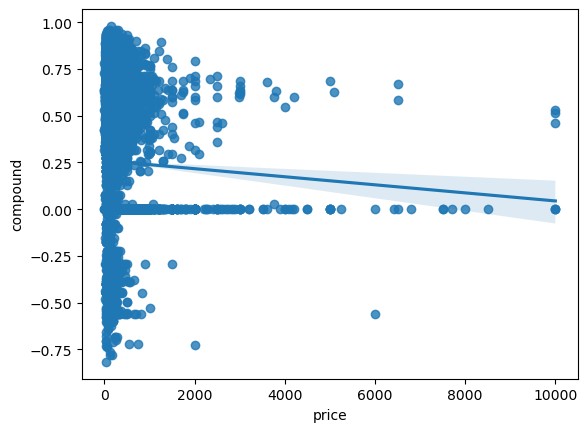

In [30]:
import seaborn as sns
sns.regplot(x = abb.price, y = abb.compound)